In [0]:
# define widgets - NEED TO DEFINE IT ONCE
# dynamic variables (pass it from ADF)
# first time runtime parameter
#dbutils.widgets.dropdown("environment", "dev", ["dev","uat","prod"])
#dbutils.widgets.dropdown("new_training", "False", ["True","False"])
#dbutils.widgets.dropdown("system_name", "bimodelapi", ["bimodelapi"])
# dbutils.widgets.text("system_name", "","")
# dbutils.widgets.remove("pbiapi")
environment = dbutils.widgets.get("environment")
new_training = dbutils.widgets.get("new_training")
system_name = dbutils.widgets.get("system_name")
if environment in {"prod"}:
    aml_compute_cluster_name = "cc-bi-ml-prod01"
else:
    aml_compute_cluster_name = "cc-bi-ml-devqa01"

print(environment, system_name, new_training, aml_compute_cluster_name)


dev bimodelapi False cc-bi-ml-devqa01

In [0]:
%run /bi_config/lib_helper

In [0]:
%run ./helper

In [0]:
# ============================= Global Variable Declaration ===================================#
from pyspark.sql.functions import (
    col,
    concat,
    lit,
    current_date,
    lag,
    lead,
    first,
    last,
    desc,
    hash,
    row_number,
)
from datetime import date, timedelta, datetime
from pyspark.sql import functions as F
from pyspark.sql import *
from delta.tables import *
from pyspark.sql.types import TimestampType, LongType, StringType

# from ibi_packages import functions as fn
import os
import stringcase
from pyspark.sql import SQLContext
from pyspark.sql.window import Window


In [0]:
#================= Load BI config parameters data (overwrite) =================#W
#static variables
environment_name = environment
filename = "automlrevfoecastconfig.json"

today = pd.to_datetime('today').normalize()
current_eom = today + pd.offsets.MonthEnd(0)
start_date = '2017-01-01'
end_date = current_eom + pd.offsets.MonthEnd(11)

notebook = os.path.basename(getNotebookPath())

input_data_path = "/dbfs/mnt/"+ environment + "/automl_rev_region_forecast/inputs/"
output_data_path = "/dbfs/mnt/"+ environment + "/automl_rev_region_forecast/outputs/"
blobstore_datadir = "revregionforecast_data/"

bi_config_parameter_filepath =  "/mnt/{}/automl_rev_region_forecast/config/{}".format(environment_name,filename)

try:
    # read JSON file
    df_bi_config_parameters = (
        spark.read.format("json")
        .option("multiline", "true")
        .load(bi_config_parameter_filepath)
    )
    df_bi_config_parameters = df_bi_config_parameters.filter(
        df_bi_config_parameters.SystemName == lit(system_name)
    )
    display(df_bi_config_parameters)

    # adding audit fields
    # df_bi_config_parameters = df_bi_config_parameters.withColumn("IBICreatedBy",lit(ibi_created_by))
    # df_bi_config_parameters = df_bi_config_parameters.withColumn("IBIUpdatedBy",lit(ibi_updated_by))
    # df_bi_config_parameters = df_bi_config_parameters.withColumn("IBICreatedDate",lit(ibi_created_date).cast(TimestampType()))
    # df_bi_config_parameters = df_bi_config_parameters.withColumn("IBIUpdatedDate",lit(ibi_updated_date).cast(TimestampType()))
    # df_bi_config_parameters = df_bi_config_parameters.withColumn('ID', row_number().over(Window.orderBy('EnvironmentName','SystemName')))

    # initializing config parameter values

    # subscription_id = "db61fd47-db56-45e3-844f-1b1f5c47990a" #you should be owner or contributor
    subscription_id = dbutils.secrets.get(
        scope="kv-bi-devqa-01-secrets", key="subscription-id"
    )

    resource_group = (
        df_bi_config_parameters.filter(
            df_bi_config_parameters.ParameterName == "ws_resource_group"
        )
        .select("ParameterValue")
        .collect()[0][0]
    )
    workspace_name = (
        df_bi_config_parameters.filter(
            df_bi_config_parameters.ParameterName == "workspace_name"
        )
        .select("ParameterValue")
        .collect()[0][0]
    )
    workspace_region = (
        df_bi_config_parameters.filter(
            df_bi_config_parameters.ParameterName == "workspace_region"
        )
        .select("ParameterValue")
        .collect()[0][0]
    )


except Exception as error:
    log_error("{} {}".format(notebook, error))



EnvironmentName,ParameterName,ParameterValue,SystemName
dev,ws_resource_group,rg-bi-automl-devqa01,bimodelapi
dev,workspace_name,mlw-bi-automl-devqa01,bimodelapi
dev,workspace_region,westus,bimodelapi


0 : ^GSPC,1 : ^FTSE,2 : ^N100,3 : ^N225,4 : 000001.SS,<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 63 non-null datetime64[ns]
 1 EURONEXT_100 63 non-null float64 
 2 FTSE_100 63 non-null float64 
 3 Nikkei_225 63 non-null float64 
 4 SP_500 63 non-null float64 
 5 SSE_Composite_Index 63 non-null float64 
dtypes: datetime64[ns](1), float64(5)
memory usage: 3.1 KB

End_of_Month,EURONEXT_100,FTSE_100,Nikkei_225,SP_500,SSE_Composite_Index
2020-11-30T00:00:00.000+0000,1088.72998046875,6266.2001953125,26433.619140625,3621.6298828125,3391.760009765625
2020-12-31T00:00:00.000+0000,1103.5400390625,6460.5,27444.169921875,3756.070068359375,3473.069091796875
2021-01-31T00:00:00.000+0000,1085.3800048828125,6407.5,27663.390625,3714.239990234375,3483.069091796875
2021-02-28T00:00:00.000+0000,1123.0799560546875,6483.39990234375,28966.009765625,3811.14990234375,3509.080078125
2021-03-31T00:00:00.000+0000,1172.469970703125,6699.2001953125,28405.51953125,3910.52001953125,3411.510009765625


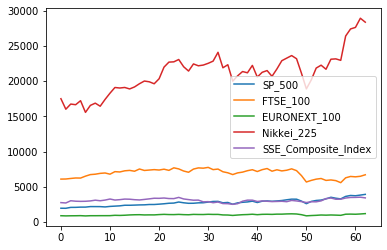

In [0]:
# download adjusted closing prices from Yahoo finance
#!pip install pandas_datareader
#!pip install yfinance
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io

pd.set_option('display.float_format', lambda x: '%.2f' % x)

start = datetime.datetime(2016, 1, 1)
end = today

# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
symbols  = ['^GSPC','^FTSE','^N100','^N225','000001.SS',]
symbols_name = ['SP_500','FTSE_100','EURONEXT_100','Nikkei_225','SSE_Composite_Index']


# create empty dataframe
stock_final = pd.DataFrame()
# iterate over each symbol
for i in symbols:  
    
    # print the symbol which is being downloaded
    print( str(symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None

#display(stock_final.tail())

stock_final1 = stock_final.copy()
stock_final1 = stock_final1.reset_index(level=stock_final1.index.names)

stock_final1["Name"].where(stock_final1["Name"] != "^N225", "Nikkei_225", inplace=True)
stock_final1["Name"].where(
    stock_final1["Name"] != "000001.SS", "SSE_Composite_Index", inplace=True
)
stock_final1["Name"].where(stock_final1["Name"] != "^GSPC", "SP_500", inplace=True)
stock_final1["Name"].where(stock_final1["Name"] != "^FTSE", "FTSE_100", inplace=True)
stock_final1["Name"].where(
    stock_final1["Name"] != "^N100", "EURONEXT_100", inplace=True
)

stock_final1['End_of_Month'] = stock_final1['Date'] + pd.offsets.MonthEnd(0)

# display(stock_final1.tail())
stock_final1 = stock_final1.sort_values("Date").groupby(["End_of_Month", "Name"]).last()
stock_final1 = stock_final1.drop(
    ["Date", "Open", "High", "Low", "Close", "Volume"], axis=1
)
stock_final1 = stock_final1.reset_index(level=stock_final1.index.names)

# Drop all Not a number values using drop method.
stock_final1.dropna(inplace=True)
stock_final_pivot = stock_final1.pivot_table(
    index="End_of_Month", values="Adj Close", margins=False, columns=["Name"]
)
# aggfunc=['sum','count'],

# revhist_pivot = revhist_pivot.rename(columns={'sum':'Revenue'})

stock_final_pivot = stock_final_pivot.reset_index(
    level=stock_final_pivot.index.names
).reset_index(drop=True)

# revhist_pivot['End_of_Month'] = pd.to_datetime(revhist_pivot['End_of_Month'])#.dt.date
# revhist_pivot.index.name = 'Date'

stock_final_pivot.fillna(0, inplace=True)
# stock_final1.query('Name=="Nikkei 225"').plot(title=str(i))
display(stock_final_pivot.info())
display(stock_final_pivot.tail())
for i in symbols_name:
    stock_final_pivot[i].plot(legend=True)

In [0]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# Load Power BI Data into pandas Dataframe
# https://stbidatadevqa01.dfs.core.windows.net/dev/automl_rev_region_forecast

# Ingest power bi data

import glob

init_time_column_name = 'End of Month'
init_time_column_name1 = 'Snapshot Date Short'
init_time_column_name2 = 'Snapshot End of Month'
try:
    talenthist = pd.read_csv(input_data_path + 'TalentHistory.csv',
                             parse_dates=[init_time_column_name])
    revhist = pd.read_csv(input_data_path + 'RevenueHistory.csv',
                          parse_dates=[init_time_column_name])
    opphist = pd.read_csv(input_data_path + 'OppHistory.csv',
                          parse_dates=[init_time_column_name])
    projhist = pd.read_csv(input_data_path + 'ProjectHistory.csv',
                           parse_dates=[init_time_column_name])
    pipetrend = pd.read_csv(input_data_path + 'PipelineTrend.csv',
                            parse_dates=[init_time_column_name,
                            init_time_column_name1])

    # pipehist = pd.read_csv(input_data_path + 'PipelineHistory*.csv',
    #                       parse_dates=[init_time_column_name,
    #                       init_time_column_name1])

    pipehist = pd.concat([pd.read_csv(f, parse_dates=[init_time_column_name,
                init_time_column_name1]) for f in
                glob.glob(input_data_path + 'PipelineHistory*.csv')],
                ignore_index=True)

    # Remove Percentage from numbers if existinput_data_path + 'PipelineHistory*.csv'

    # opphist1.filter(like="Win_Rate", axis=1).columns

    cols_float1 = ['Win Rate']
    remove_percetage(opphist, cols_float1)
    cols_float2 = ['Yield']
    remove_percetage(pipehist, cols_float2)

    for x in [
        pipehist,
        talenthist,
        revhist,
        opphist,
        projhist,
        pipetrend,
        ]:

    # replace blank with underscore

        x.columns = x.columns.astype(str).str.replace(' ', '_')

    # remove contrib or managing

        x.columns = x.columns.astype(str).str.replace('Contrib_', '')
        x.columns = x.columns.astype(str).str.replace('Managing_', '')

        print (get_df_name(x), ':', x.shape)
        display(x.info())
        display(x.tail())
        
except Exception as error:

    log_error('{} {}'.format(notebook, error))

pipehist : (80096, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80096 entries, 0 to 80095
Data columns (total 9 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Snapshot_Date_Short 80096 non-null datetime64[ns]
 1 Relative_Snapshot_Month_Offset 80096 non-null int64 
 2 End_of_Month 80096 non-null datetime64[ns]
 3 Relative_Month_Offset 80096 non-null int64 
 4 Sub_Region_Code 78853 non-null object 
 5 Pipeline_Type 80096 non-null object 
 6 Pipeline 80005 non-null object 
 7 Yield 61678 non-null float64 
 8 Yield_Amount 64423 non-null object 
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 5.5+ MB
/databricks/spark/python/pyspark/sql/pandas/conversion.py:300: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field Sub_Region_Code. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion from Arrow: null
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline_Type,Pipeline,Yield,Yield_Amount
2020-10-11T00:00:00.000+0000,-5,2020-11-30T00:00:00.000+0000,-4,NaN,Opportunity,130789.38,NaN,NaN
2020-10-11T00:00:00.000+0000,-5,2020-12-31T00:00:00.000+0000,-3,NaN,Opportunity,143245.52,NaN,NaN
2020-10-18T00:00:00.000+0000,-5,2020-10-31T00:00:00.000+0000,-5,NaN,Opportunity,62280.66,NaN,NaN
2020-10-18T00:00:00.000+0000,-5,2020-11-30T00:00:00.000+0000,-4,NaN,Opportunity,130789.38,NaN,NaN
2020-10-18T00:00:00.000+0000,-5,2020-12-31T00:00:00.000+0000,-3,NaN,Opportunity,143245.52,NaN,NaN


talenthist : (2526, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2526 entries, 0 to 2525
Data columns (total 5 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 2526 non-null datetime64[ns]
 1 Sub_Region_Code 2430 non-null object 
 2 Journey_Level 2526 non-null object 
 3 Headcount 2150 non-null float64 
 4 Headcount_Contingent 892 non-null float64 
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 98.8+ KB

End_of_Month,Sub_Region_Code,Journey_Level,Headcount,Headcount_Contingent
2017-01-31T00:00:00.000+0000,Global,Team,19.0,null
2017-01-31T00:00:00.000+0000,Global,Director,11.5,null
2017-01-31T00:00:00.000+0000,Global,Enterprise,15.8,null
2017-01-31T00:00:00.000+0000,Global,Unknown,1.0,5.0
2017-01-31T00:00:00.000+0000,null,Unknown,null,5.0


revhist : (415, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 3 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 415 non-null datetime64[ns]
 1 Sub_Region_Code 414 non-null object 
 2 Revenue 415 non-null object 
dtypes: datetime64[ns](1), object(2)
memory usage: 9.9+ KB

End_of_Month,Sub_Region_Code,Revenue
2021-04-30T00:00:00.000+0000,Play Lab,250000.00
2021-05-31T00:00:00.000+0000,Academy,960645.00
2021-05-31T00:00:00.000+0000,Play Lab,125000.00
2021-06-30T00:00:00.000+0000,Academy,48000.00
2021-06-30T00:00:00.000+0000,Play Lab,50000.00


opphist : (593, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 7 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 593 non-null datetime64[ns]
 1 Sub_Region_Code 527 non-null object 
 2 Opportunity_Period_Count 256 non-null float64 
 3 Opportunity_Count 593 non-null int64 
 4 Current_Opp._Period_Value 242 non-null float64 
 5 Opportunity_Value 584 non-null float64 
 6 Win_Rate 189 non-null float64 
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 32.6+ KB

End_of_Month,Sub_Region_Code,Opportunity_Period_Count,Opportunity_Count,Current_Opp._Period_Value,Opportunity_Value,Win_Rate
2023-12-31T00:00:00.000+0000,Academy,null,4,null,14925.0,null
2023-12-31T00:00:00.000+0000,Centers of Excellence,null,11,null,1300000.0,null
2023-12-31T00:00:00.000+0000,Play Lab,null,6,null,1094000.0,null
2023-12-31T00:00:00.000+0000,Global,null,2,null,233601.0,null
2023-12-31T00:00:00.000+0000,null,null,11,null,2267016.0,null


projhist : (639, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 5 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 End_of_Month 639 non-null datetime64[ns]
 1 Sub_Region_Code 636 non-null object 
 2 Project_Period_Price 369 non-null float64 
 3 Project_Price 638 non-null float64 
 4 Conversions 320 non-null object 
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 25.1+ KB
/databricks/spark/python/pyspark/sql/pandas/conversion.py:300: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field Conversions. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Context: Unsupported type in conversion from Arrow: null
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

End_of_Month,Sub_Region_Code,Project_Period_Price,Project_Price,Conversions
2023-12-31T00:00:00.000+0000,North America,NaN,1.17131827E8,NaN
2023-12-31T00:00:00.000+0000,Europe,NaN,1.538432393E7,NaN
2023-12-31T00:00:00.000+0000,Centers of Excellence,NaN,8438954.0,NaN
2023-12-31T00:00:00.000+0000,Play Lab,NaN,1388384.0,NaN
2023-12-31T00:00:00.000+0000,Global,NaN,8913323.0,NaN


pipetrend : (12823, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12823 entries, 0 to 12822
Data columns (total 5 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Snapshot_Date_Short 12823 non-null datetime64[ns]
 1 End_of_Month 12823 non-null datetime64[ns]
 2 Sub_Region_Code 12306 non-null object 
 3 Pipeline_Type 12823 non-null object 
 4 Pipeline_Trend 12823 non-null object 
dtypes: datetime64[ns](2), object(3)
memory usage: 501.0+ KB

Snapshot_Date_Short,End_of_Month,Sub_Region_Code,Pipeline_Type,Pipeline_Trend
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Play Lab,Active Unrecognized,354467.35
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Play Lab,Opportunity,46803.36
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Global,Active Unrecognized,342912.09
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,Global,Opportunity ML,54484.25
2021-03-24T00:00:00.000+0000,2021-06-30T00:00:00.000+0000,null,Opportunity,256717.84
